<a href="https://colab.research.google.com/github/sonalshreya25/respiratoryDiagnostic/blob/main/RespiratoryDiagnosis_AlphaNeurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Enhancing Medical Diagnosis through Spectroscopy-Based Respiratory Sound Analysis**

## Introduction
AI-based diagnostic systems have immense potential in transforming healthcare, particularly in the timely detection of respiratory diseases. Nonetheless, lack of interpretability in octopus nets remains one of the chief barriers to their clinical deployment, particularly in children. Models also promise to empower clinicians, and they cannot be simply high-performing systems but rather transparent systems that can explain how and why a given prediction was made so that clinical safety and trust can be built.

This project aims to create an interpretable deep learning pipeline for respiratory sound classification. This paper attempts to classify respiratory diseases from lung sound spectrograms using the ICBHI 2017 Lung Sound Dataset. We utilize Convolutional Neural Networks (CNNs) because of their success in learning spatial patterns from audio spectrogram images. In an effort to address the black-box nature of CNNs, we appended Grad-CAM++, a state-of-the-art explainability technique, to produce visual explanations identifying which parts of spectrograms contribute most to the model’s predictions.

With this approach, we seek to achieve not just accurate classification performance, but also robust and clinically relevant local visualizations that render decisions interpretable to healthcare providers. Early results show good accuracy and intuition in visual interpretation. We hope this project will thus fill the first steps gap between AI performance and clinical trust in their plausible use and therefore provide the basis for future real-world validation and deployment of explainable AI in a health-care context.

##Problem Statement
Convolutional neural networks (CNNs) are increasingly used to classify respiratory sounds from spectrograms, but their lack of interpretability remains a critical barrier to clinical adoption. Without insight into the way CNN arrives at its predictions, physicians are unlikely to trust or act on its output. This opacity is especially problematic in medical contexts where diagnostic decisions carry high stakes. To address this, our project integrates Grad-CAM++ to produce fine-grained visual explanations, enabling clinicians to understand, evaluate, and potentially validate the CNN’s focus areas on spectrograms.
## Objective
This project aims to bridge the gap between AI-driven performance and clinical trust, paving the way for future real-world validation and deployment of explainable AI systems in healthcare settings. Specifically, we:
* Use Transfer Learning to train CNN architecture capable of classifying respiratory diseases from lung sound spectrograms.
* Integrate Grad-CAM++ to produce detailed, context-based visual explanations for each prediction.
* 	Evaluate the alignment between Grad-CAM++ outputs and known clinical features (such as time-frequency patterns associated with crackles and wheezes).
* 	Assess the impact of explainability integration on overall model performance and usability.
Using the ICBHI 2017 Respiratory Sound Dataset, our goal is to improve clinical trust in CNN-based models by making their predictions transparent and easier for physicians to validate.- https://bhichallenge.med.auth.gr/ICBHI_2017_Challenge,.



#### Methodology
- Spectrogram generation from audio cycles
- Training a ResNet18 CNN with a custom classification head
- Class-weighted loss function to handle imbalance
- Use of Grad-CAM++ for post-hoc explainability
- Logging of metrics and artifacts to Weights & Biases (wandb)

#### Tools & Libraries
- Python, PyTorch, torchvision, torchaudio
- matplotlib, sklearn, pandas, wandb
- TorchCAM for Grad-CAM++

## Environment Setup & Data Path Initialization

This section sets up the environment for the ICBHI project by importing required libraries for data handling, audio processing, and visualization. It also defines the device (GPU or CPU) for PyTorch operations and initializes paths to the dataset directories and annotation files.


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set Paths
import os
import pandas as pd
from glob import glob
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Assigning Google drive path to save Spectograms, gradcam heatmaps
root_dir = "C:/Users/sumit/OneDrive/Desktop/Deep Learning_ICBHI Project/ICBHI_final_database"
audio_dir = os.path.join(root_dir, "recordings_annotations")
diagnosis_file = os.path.join(root_dir, "diagnosis_data.txt")
train_patients_file = os.path.join(root_dir, "train_data.txt")
test_patients_file = os.path.join(root_dir, "test_data.txt")
train_test_file = os.path.join(root_dir, "train_test_data.txt")
events_folder = os.path.join(root_dir, "events/events")


Using device: cuda


## Torch & Environment Initialization for Reproducibility

This section initializes the environment for model training by importing essential PyTorch and torchvision libraries, along with Weights & Biases for tracking. It sets the computation device to GPU if available and configures a random seed to ensure reproducibility of results across runs. Deterministic settings are applied for CUDA to avoid non-deterministic behaviors during training.


In [ ]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np


# Checking for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setting seed for repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensuring deterministic behavior for CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda:0


## Weights & Biases (wandb) Run Initialization

This line initializes a new Weights & Biases (wandb) run under the specified entity and project name. It allows experiment tracking, logging of metrics, and visualization of model performance over time for the respiratory diagnosis project.


In [ ]:
# Initializing Weights & Biases
wandb.init(entity="usf-alpha-neurons",project="respiratory_diagnosis")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sonalshreya (usf-alpha-neurons) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Dataset Overview
We used the ICBHI 2017 Respiratory Sound Dataset, the largest publicly available annotated lung sound collection for research. It contains 920 audio recordings from 126 patients across two countries (Portugal and Greece), totaling about 5.5 hours of respiratory audio and segmented into 6,898 respiratory cycles.

These cycles are labeled by medical professionals into four classes: normal, crackles, wheezes, or both crackles and wheezes.
The dataset also includes patient diagnosis metadata, covering conditions like COPD (chronic obstructive pulmonary disease), asthma, pneumonia, bronchiectasis, URTI (upper respiratory tract infection), and more.
Patient Distribution per Diagnosis:
* COPD: 64 (Highly dominant)
* 	Healthy: 26
* 	URTI (Upper Respiratory Tract Infection): 14
* 	Bronchiectasis: 7
* 	Pneumonia: 6
* 	Bronchiolitis: 6
* 	LRTI (Lower Respiratory Tract Infection): 2
*   Asthma: 1

**Trends Observed based on Exploratory Data Analysis:**
* 	Patients labeled “healthy” mostly show no abnormal sounds, while COPD cases frequently have both crackles and wheezes.
* 	Asthma and URTI cases show stronger wheeze signals.
* 	Chi-square analysis confirmed that abnormal sound types are significantly associated with diagnosis, validating their clinical importance.
*	Feature correlation heatmaps indicated that the presence of “both” crackles and wheezes negatively correlates with health (i.e., more severe disease), while “none” correlates positively with healthy patients.


## Loading Diagnosis Labels and Patient Split Information

This section loads the diagnosis labels and patient split information. It reads the `diagnosis_data.txt` file into a DataFrame and converts patient IDs to string format. It also reads train and test patient IDs from their respective text files to prepare for data partitioning.


In [ ]:
# Load diagnosis and patient split data
diagnosis_df = pd.read_csv(diagnosis_file, header=None, sep='\t', names=['Patient_ID', 'Diagnosis'])
diagnosis_df['Patient_ID'] = diagnosis_df['Patient_ID'].astype(str)

with open(train_patients_file, 'r') as f:
    train_patients = [line.strip() for line in f.readlines()]

with open(test_patients_file, 'r') as f:
    test_patients = [line.strip() for line in f.readlines()]


## Scanning and Organizing Audio File Metadata

This block scans all `.wav` audio files and their corresponding annotation `.txt` files in the dataset directory. It extracts patient IDs, matches them with diagnosis labels, and assigns each sample to the train or test split. The collected metadata is stored in a DataFrame for further processing.


In [ ]:
# Scan all audio + annotation files
data = []

for wav_file in tqdm(glob(os.path.join(audio_dir, "*.wav"))):
    base_name = os.path.basename(wav_file)
    patient_id = base_name.split('_')[0]
    txt_file = wav_file.replace(".wav", ".txt")

    if not os.path.exists(txt_file):
        continue

    diagnosis = diagnosis_df.loc[diagnosis_df['Patient_ID'] == patient_id, 'Diagnosis']
    diagnosis = diagnosis.values[0] if not diagnosis.empty else None

    if patient_id in train_patients:
        split = 'train'
    elif patient_id in test_patients:
        split = 'test'
    else:
        split = 'unknown'

    data.append({
        'Patient_ID': patient_id,
        'File': base_name,
        'WAV_Path': wav_file,
        'TXT_Path': txt_file,
        'Diagnosis': diagnosis,
        'Split': split
    })

df = pd.DataFrame(data)


100%|██████████| 920/920 [00:00<00:00, 966.84it/s] 


## Extracting Crackle and Wheeze Events from Annotation Files

This function scans event annotation files to detect the presence of crackles and wheezes in each audio recording. It returns binary indicators for both, which are added as new columns in the main DataFrame to enrich the dataset with labeled respiratory events.


In [ ]:
# Extract crackle and wheeze events from event files
def extract_events(file_name):
    base_name = os.path.splitext(file_name)[0]
    events_file = os.path.join(events_folder, base_name + '_events.txt')
    has_crackle, has_wheeze = 0, 0
    try:
        with open(events_file, 'r') as f:
            for line in f:
                if 'crackle' in line.lower():
                    has_crackle = 1
                if 'wheeze' in line.lower():
                    has_wheeze = 1
    except FileNotFoundError:
        pass
    return pd.Series([has_crackle, has_wheeze])

df[['Crackles', 'Wheezes']] = df['File'].apply(extract_events)


## Updating Train/Test Split Using Refined Labels

This section updates the train/test split information using a refined split file. It reads the updated split data, merges it with the main DataFrame on the audio file name, and replaces the previous split assignments. Any missing entries are labeled as 'unknown'.


In [ ]:
# Merge refined train/test data from shared file
split_df = pd.read_csv(
    train_test_file,
    sep='\t',
    header=None,
    names=['FileBase', 'Split']
)
split_df['File'] = split_df['FileBase'] + '.wav'
split_df.drop(columns='FileBase', inplace=True)

df = df.drop(columns=['Split'])  # Remove old one
df = df.merge(split_df, on='File', how='left')
df['Split'] = df['Split'].fillna('unknown')


## Displaying Final Combined DataFrame

This step prints the shape of the final DataFrame and displays its first few rows. It helps verify that all audio metadata, diagnosis labels, event annotations, and split assignments have been successfully combined into a single structured dataset.


In [ ]:
# Display the final DataFrame
print(" Final DataFrame shape:", df.shape)
df.head()


 Final DataFrame shape: (920, 8)


,Patient_ID,File,WAV_Path,TXT_Path,Diagnosis,Crackles,Wheezes,Split
0,101,101_1b1_Al_sc_Meditron.wav,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,URTI,0,0,test
1,101,101_1b1_Pr_sc_Meditron.wav,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,URTI,0,0,test
2,102,102_1b1_Ar_sc_Meditron.wav,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,Healthy,0,0,test
3,103,103_2b2_Ar_mc_LittC2SE.wav,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,Asthma,0,1,train
4,104,104_1b1_Al_sc_Litt3200.wav,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,C:/Users/sumit/OneDrive/Desktop/Deep Learning_...,COPD,0,0,test


## Spectrogram Generation and Saving for Model Input

This block defines a function to generate and save spectrograms from `.wav` audio files. The audio signal is loaded using `librosa`, limited to a specific duration (default 3 seconds). A Short-Time Fourier Transform (STFT) is applied to convert the waveform into a time-frequency representation, which is then converted into a decibel (dB) scale using `librosa.amplitude_to_db`.

The spectrogram is normalized to a [0,1] range and saved as a `.npy` file for input into machine learning models. Additionally, a `.png` image version is saved for visualization, using `librosa.display.specshow` with logarithmic frequency scale. This step ensures that each audio file is represented both visually and numerically for use in AI model training and inspection.


In [ ]:
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Creating output folder
output_dir = os.path.join(root_dir, "spectrograms_high_resolution")
os.makedirs(output_dir, exist_ok=True)

# Spectrogram helper
def generate_and_save_spectrogram(wav_path, file_name, duration=3, n_fft=2048, hop_length=512):
    y, sr = librosa.load(wav_path, sr=None, duration=duration)

    # STFT + dB conversion
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Normalize for training (.npy)
    S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))

    # Save .npy
    npy_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
    np.save(npy_path, S_db_norm)

    # Save .png
    png_path = os.path.join(output_dir, file_name.replace(".wav", ".png"))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    return npy_path, png_path


### Spectrogram Generation with Enhanced Visual & Signal Resolution

This section generates high-resolution spectrograms from `.wav` audio files while also applying optional pitch-shift augmentation for class imbalance handling.

1. **Audio Loading & Augmentation**: Each audio file is loaded with a fixed duration (3 seconds). For underrepresented classes like 'Asthma' and 'LRTI' in the training set, pitch-shifting is applied to introduce variability and mitigate class imbalance.

2. **Spectrogram Generation**: The Short-Time Fourier Transform (STFT) is computed with a large FFT window (`n_fft = 4096`) and small hop size (`hop_length = 256`) to increase frequency and temporal resolution respectively. The result is converted to decibel (dB) scale and normalized.

3. **Output Formats**:
   - `.npy`: Normalized spectrogram arrays saved for use in training deep learning models.
   - `.png`: High-resolution spectrogram images (12x6 inches at 300 DPI) saved for visualization or interpretability techniques like Grad-CAM.

4. **Batch Processing**: The function loops through all entries in the DataFrame, generating and saving spectrograms unless they already exist. Paths to these files are stored back into the DataFrame for further use.

This process ensures that each audio sample is transformed into a rich, high-resolution representation for both learning and explainability.



In [ ]:
# Spectrogram Generation with Enhanced Visual & Signal Resolution

import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Creating output folder
output_dir = os.path.join(root_dir, "spectrograms_high_resolution")
os.makedirs(output_dir, exist_ok=True)

# Spectrogram Parameters
n_fft = 4096         # Increased FFT size → better frequency resolution
hop_length = 256     # Smaller hop → better time resolution
duration = 3         # Duration (sec) to load from audio

# Pitch shift augmentation for rare training classes
def augment_pitch_shift(y, sr):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))

# High-resolution spectrogram generation + saving
def generate_and_save_spectrogram(wav_path, file_name, diagnosis=None, split=None):
    y, sr = librosa.load(wav_path, sr=None, duration=duration)

    # Augmenting rare classes only during training
    rare_classes = ['Asthma', 'LRTI']
    if split == 'train' and diagnosis in rare_classes:
        y = augment_pitch_shift(y, sr)

    # Computing STFT and dB spectrogram
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Normalizing for .npy output
    S_db_norm = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))

    # Saving .npy file (used for model input)
    npy_path = os.path.join(output_dir, file_name.replace(".wav", ".npy"))
    np.save(npy_path, S_db_norm)

    # Save high-res .png for Grad-CAM overlays
    png_path = os.path.join(output_dir, file_name.replace(".wav", ".png"))
    plt.figure(figsize=(12, 6), dpi=300)  #  Bigger image & higher DPI
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(png_path, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

    return npy_path, png_path

from tqdm import tqdm

# Looping through all rows in df and generate spectrograms
for idx, row in tqdm(df.iterrows(), total=len(df), desc=" Generating Spectrograms"):
    file = row['File']
    npy_path = os.path.join(output_dir, file.replace('.wav', '.npy'))
    png_path = os.path.join(output_dir, file.replace('.wav', '.png'))

    # Skipping if both npy and png already exist (i.e., previous run completed this file)
    if os.path.exists(npy_path) and os.path.exists(png_path):
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
        continue

    # Else process and save
    try:
        npy_path, png_path = generate_and_save_spectrogram(
            row['WAV_Path'],
            row['File'],
            diagnosis=row['Diagnosis'],
            split=row['Split']
        )
        df.at[idx, 'Spectrogram_Array'] = npy_path
        df.at[idx, 'Spectrogram_Image'] = png_path
    except Exception as e:
        print(f" Failed to process {row['File']}: {e}")



🔄 Generating Spectrograms: 100%|██████████| 920/920 [00:00<00:00, 3046.88it/s]


### Save Final Metadata with Spectrogram Paths

The final DataFrame, now enriched with spectrogram array and image paths, is saved as a `.pkl` (pickle) file. This allows for efficient loading in later stages of the pipeline without needing to reprocess audio files or regenerate spectrograms.



In [ ]:
df.to_pickle(os.path.join(root_dir, "df_with_spectrograms.pkl"))
print("Saved metadata with spectrogram paths.")


Saved metadata with spectrogram paths.


### Label Encoding and Diagnosis Grouping

This section prepares diagnosis labels for model training and analysis. It filters out unknown patient samples and encodes original diagnosis labels using `LabelEncoder`. Diagnoses are also grouped into medically-informed superclasses (e.g., 'Obstructive', 'Infectious') to simplify classification and improve interpretability.

A second encoding is applied to these grouped classes for modeling purposes. Finally, a bar chart is plotted to visualize the distribution of diagnosis groups across train and test splits, helping assess data balance and class representation.

### Addressing Class Imbalance
The ICBHI 2017 dataset presents significant class imbalance, with COPD dominating over 50% of cases and rare conditions like asthma and LRTI appearing in very few samples. To handle this, we applied three key strategies:
* Grouping Diagnoses: We consolidated the original eight diagnostic categories into broader super-classes: obstructive (COPD, asthma), infectious (pneumonia, URTI, LRTI, bronchiolitis), structural (bronchiectasis), and healthy. This reduced data sparsity and allowed the model to focus on meaningful clinical groupings.
* 	Weighted Loss: We used weighted cross-entropy loss to give underrepresented classes higher importance, ensuring the model learned from minority cases and not just majority patterns.
* 	Data Augmentation: We expanded the rare-class samples through spectrogram-level augmentations, including time masking, frequency masking, pitch shifting, noise injection, and controlled flipping, increasing data diversity and helping prevent overfitting.




✅ Total valid samples after filtering: 919
🔠 Original Encoded Classes: ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
📌 Grouped Classes: ['Healthy', 'Infectious', 'Obstructive', 'Structural']


C:\Users\sumit\AppData\Local\Temp\ipykernel_26076\3748789149.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sumit\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


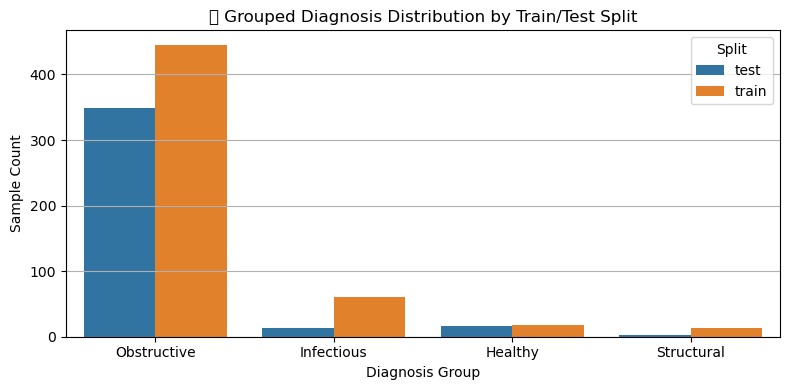

In [ ]:
# Filter unknown patients
df = df[df['Split'].isin(['train', 'test'])].reset_index(drop=True)
print(f"Total valid samples after filtering: {df.shape[0]}")

# Encode original diagnosis labels (optional but useful for analysis)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['EncodedLabel'] = label_encoder.fit_transform(df['Diagnosis'].astype(str))
print("Original Encoded Classes:", list(label_encoder.classes_))

# Group diagnoses into medically-informed superclasses
group_mapping = {
    'COPD': 'Obstructive',
    'Asthma': 'Obstructive',
    'Pneumonia': 'Infectious',
    'Bronchitis': 'Infectious',
    'URTI': 'Infectious',
    'LRTI': 'Infectious',
    'Bronchiolitis': 'Infectious',
    'Bronchiectasis': 'Structural',
    'Healthy': 'Healthy'
}

df['Diagnosis_Group'] = df['Diagnosis'].map(group_mapping)

# Encode new grouped classes
from sklearn.preprocessing import LabelEncoder
group_encoder = LabelEncoder()
df['GroupLabel'] = group_encoder.fit_transform(df['Diagnosis_Group'])
print("Grouped Classes:", list(group_encoder.classes_))

# Visualize group-wise label distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Diagnosis_Group', order=df['Diagnosis_Group'].value_counts().index, hue='Split')
plt.title("Grouped Diagnosis Distribution by Train/Test Split")
plt.xlabel("Diagnosis Group")
plt.ylabel("Sample Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Stratified Train-Test Split Based on Diagnosis Group

This section performs an 80:20 train-test split using `GroupLabel` as the stratification criterion to ensure balanced class distribution across both sets. It removes any samples with missing group labels and applies `train_test_split` with a fixed random seed for reproducibility. The resulting `train_df` and `test_df` are saved as pickle files for later use. Class distributions are printed to verify that stratification was successful.



In [ ]:
# Stratified 80:20 split based on GroupLabel
from sklearn.model_selection import train_test_split

# Remove any NaN GroupLabel just in case
df = df[df['GroupLabel'].notna()].reset_index(drop=True)

# Perform stratified split
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['GroupLabel'],
    random_state=42
)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Save to .pkl for reproducibility
train_split_path = os.path.join(root_dir, "train_split_stratified.pkl")
test_split_path = os.path.join(root_dir, "test_split_stratified.pkl")

train_df.to_pickle(train_split_path)
test_df.to_pickle(test_split_path)

# Show result summary
print(f"Stratified Train split saved to: {train_split_path}")
print(f"Stratified Test split saved to: {test_split_path}")
print(f"Train class distribution:\n{train_df['GroupLabel'].value_counts()}")
print(f"Test class distribution:\n{test_df['GroupLabel'].value_counts()}")


📁 Stratified Train split saved to: C:/Users/sumit/OneDrive/Desktop/Deep Learning_ICBHI Project/ICBHI_final_database\train_split_stratified.pkl
📁 Stratified Test split saved to: C:/Users/sumit/OneDrive/Desktop/Deep Learning_ICBHI Project/ICBHI_final_database\test_split_stratified.pkl
🔢 Train class distribution:
GroupLabel
2    635
1     59
0     28
3     13
Name: count, dtype: int64
🔢 Test class distribution:
GroupLabel
2    159
1     15
0      7
3      3
Name: count, dtype: int64


### Reloading Stratified Train-Test Splits

This step reloads the previously saved stratified train and test DataFrames from disk using `pd.read_pickle`. It ensures that subsequent experiments can reuse the exact same splits for consistency and reproducibility. The shapes and class distributions are printed to confirm successful loading.


In [ ]:
# Reload stratified train/test split
train_split_path = os.path.join(root_dir, "train_split_stratified.pkl")
test_split_path = os.path.join(root_dir, "test_split_stratified.pkl")

train_df = pd.read_pickle(train_split_path)
test_df = pd.read_pickle(test_split_path)

print(f" - Reloaded Stratified Splits:")
print(f" - Train shape: {train_df.shape}")
print(f" - Test shape: {test_df.shape}")
print(f" - Train class counts:\n{train_df['GroupLabel'].value_counts()}")
print(f" - Test class counts:\n{test_df['GroupLabel'].value_counts()}")


🧪 Reloaded Stratified Splits:
 - Train shape: (735, 13)
 - Test shape: (184, 13)
 - Train class counts:
GroupLabel
2    635
1     59
0     28
3     13
Name: count, dtype: int64
 - Test class counts:
GroupLabel
2    159
1     15
0      7
3      3
Name: count, dtype: int64


### Custom PyTorch Dataset: `Spectrogram2DDataset`

This class defines a custom PyTorch `Dataset` to load 2D spectrogram images and their corresponding labels for model training. It reads file paths and labels from a provided DataFrame, opens each spectrogram image using PIL, applies optional transformations (e.g., resizing, normalization), and returns the image-label pair. This setup enables seamless integration with PyTorch’s `DataLoader` for batch training.



In [ ]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

class Spectrogram2DDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'Spectrogram_Image']
        label = self.df.loc[idx, 'GroupLabel']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


### Image Transforms, Dataset Wrapping, and Dataloader Creation

This section defines image preprocessing steps using `torchvision.transforms`, including resizing to 224×224 and converting images to tensors. It wraps the training and testing DataFrames using the custom `Spectrogram2DDataset` and initializes PyTorch `DataLoader` objects for batching and shuffling.

A few sample spectrogram images from the training set are then logged to Weights & Biases (wandb) for visual inspection, helping verify correct data loading and labeling before model training.



In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_ds = Spectrogram2DDataset(train_df, transform=img_transforms)
test_ds = Spectrogram2DDataset(test_df, transform=img_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

print("✅ Dataloaders are ready!")

sample_dataset = Spectrogram2DDataset(train_df, transform=img_transforms)

# Log 3 spectrogram images to wandb
for i in range(3):  # or use random indices
    image, label = sample_dataset[i]

    # wandb.Image takes PIL or tensor directly
    wandb.log({
        f"Sample Spectrogram {i+1}": wandb.Image(image, caption=f"Label: {label}")
    })


✅ Dataloaders are ready!


In this project, we explored multiple deep learning architectures to classify respiratory diseases based on spectrogram inputs. Our primary goal was not only to achieve strong predictive performance but also to integrate explainability, enabling clinicians to understand the basis of each model decision.
We tested three model types:
1.	**1D Convolutional Neural Network (1D CNN):**
This model was applied directly to raw audio waveforms, focusing on temporal signal patterns. While it captured some relevant features, it lacked compatibility with visual explainability methods and struggled to represent the combined time–frequency dynamics critical for respiratory sound analysis.
2.	**Gated Recurrent Unit (GRU):**
We also experimented with GRU networks, which are designed for sequential data and can model temporal dependencies effectively. However, GRUs are inherently one-dimensional and do not produce intermediate spatial feature maps, making it challenging to apply tools like Grad-CAM++ for visual interpretation.
3.	**2D Convolutional Neural Network (ResNet-18, Transfer Learning):**
Our final and best-performing model was ResNet-18 architecture, pretrained on ImageNet and fine-tuned on our spectrogram dataset. ResNet-18 offers a robust convolutional backbone with residual connections, allowing the model to capture both local and global patterns in spectrogram images. Most importantly, its 2D convolutional layers are fully compatible with Grad-CAM++, enabling detailed, class-specific visual explanations of what the model focuses on when making predictions.

We selected ResNet-18, a deep convolutional neural network with 18 layers and residual (skip) connections, which enable efficient training of deep architectures by preventing vanishing gradient issues. ResNet-18 is particularly well-suited for spectrogram-based tasks because its 2D convolutions can learn both local (e.g., crackle bursts) and global (e.g., wheeze bands) patterns across time and frequency.

 By using pretrained ImageNet weights, we leveraged transfer learning, allowing the model to generalize well even with the limited size and class imbalance of the ICBHI dataset.

Importantly, ResNet-18 integrates smoothly with Grad-CAM++, enabling detailed, class-specific visual explanations — a critical feature for developing interpretable AI tools for healthcare. Compared to the 1D CNN and GRU models we tested, ResNet-18 consistently achieved superior classification accuracy while meeting our project’s explainability goals.


### Transfer Learning with ResNet-18

This section initializes a pretrained ResNet-18 model for spectrogram classification. The model is loaded with default pretrained weights (`ResNet18_Weights.DEFAULT`) and moved to the appropriate device (CPU or GPU). To leverage transfer learning, all layers are frozen except for the last convolutional block (`layer4`) and the final fully connected (`fc`) layer. The final layer is replaced to match the number of target diagnosis groups in the dataset.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_df['GroupLabel'].unique())

# Load ResNet18 with pretrained weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last two layers: layer4 and fc
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True

# Replace the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


### Weighted Loss Function and Optimizer Setup

To address class imbalance in the training data, this section computes class weights using `sklearn`'s `compute_class_weight` and integrates them into a `CrossEntropyLoss` function. This ensures that minority classes are not underrepresented during training. The model is optimized using the Adam optimizer with specified learning rate and weight decay.

Additionally, key hyperparameters and configuration details are logged to Weights & Biases (wandb) for experiment tracking and reproducibility.



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import torch

classes = np.unique(train_df['GroupLabel'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_df['GroupLabel']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# defining the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
learning_rate = 1e-4
weight_decay = 1e-5
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay
)
# Logging metrics to Weights and Biases
wandb.config.update({
    "model": "ResNet18",
    "loss_function": "CrossEntropyLoss (weighted)",
    "optimizer": "Adam",
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "class_weights": {
        f"Group {cls}": float(weight)
        for cls, weight in zip(classes, class_weights)
    }
})

### Model Training Loop (Epochs)

This section defines the training loop for 20 epochs. For each batch, the model performs a forward pass, computes the weighted cross-entropy loss, and updates only the trainable parameters using the Adam optimizer. Training predictions and labels are collected to calculate accuracy at the end of each epoch. Key metrics such as loss and accuracy are logged to Weights & Biases (wandb) for real-time experiment tracking and visualization.



In [ ]:
from sklearn.metrics import accuracy_score

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for X, y in train_loader:
        # ✅ Move data to GPU and convert labels to long (required by CrossEntropyLoss)
        X, y = X.to(device), y.long().to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # 📊 Metrics
    avg_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)

    # 🪄 Log to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "train_accuracy": train_acc
    })

    print(f"📚 Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f}")


📚 Epoch 1 | Train Loss: 1.1775 | Train Acc: 0.2694
📚 Epoch 2 | Train Loss: 0.3268 | Train Acc: 0.7769
📚 Epoch 3 | Train Loss: 0.1563 | Train Acc: 0.9442
📚 Epoch 4 | Train Loss: 0.0960 | Train Acc: 0.9796
📚 Epoch 5 | Train Loss: 0.0659 | Train Acc: 0.9810
📚 Epoch 6 | Train Loss: 0.0401 | Train Acc: 0.9959
📚 Epoch 7 | Train Loss: 0.0309 | Train Acc: 0.9946
📚 Epoch 8 | Train Loss: 0.0177 | Train Acc: 1.0000
📚 Epoch 9 | Train Loss: 0.0156 | Train Acc: 1.0000
📚 Epoch 10 | Train Loss: 0.0122 | Train Acc: 1.0000
📚 Epoch 11 | Train Loss: 0.0115 | Train Acc: 1.0000
📚 Epoch 12 | Train Loss: 0.0081 | Train Acc: 1.0000
📚 Epoch 13 | Train Loss: 0.0083 | Train Acc: 1.0000
📚 Epoch 14 | Train Loss: 0.0078 | Train Acc: 1.0000
📚 Epoch 15 | Train Loss: 0.0047 | Train Acc: 1.0000
📚 Epoch 16 | Train Loss: 0.0064 | Train Acc: 1.0000
📚 Epoch 17 | Train Loss: 0.0058 | Train Acc: 1.0000
📚 Epoch 18 | Train Loss: 0.0041 | Train Acc: 1.0000
📚 Epoch 19 | Train Loss: 0.0038 | Train Acc: 1.0000
📚 Epoch 20 | Train Lo

### Model Evaluation on Test Set

This section evaluates the trained model on the test dataset. Predictions and class probabilities are collected using a no-gradient context to reduce memory usage. Standard classification metrics—accuracy, precision, recall, and F1 score—are calculated using weighted averaging to account for class imbalance.

Multi-class ROC AUC is also computed using a one-vs-rest approach. A classification report provides per-class performance breakdown. All metrics are logged to Weights & Biases (wandb) for tracking and comparison across runs. If AUC computation fails due to class issues, it is gracefully handled with an informative message.



In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report
)
import torch.nn.functional as F
import numpy as np

# Inference on TEST SET
model.eval()
test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Compute weighted metrics
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

# Compute AUC (multi-class)
try:
    test_auc = roc_auc_score(
        y_true=np.eye(num_classes)[test_labels],
        y_score=test_probs,
        average='weighted',
        multi_class='ovr'
    )
except Exception as e:
    test_auc = None
    print("AUC could not be computed:", str(e))

# Print classification report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=group_encoder.classes_))
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
if test_auc is not None:
    print(f"Test ROC AUC:   {test_auc:.4f}")

# Log to Weights & Biases
import wandb
wandb.log({
    "test/accuracy": test_acc,
    "test/f1_score": test_f1,
    "test/precision": test_precision,
    "test/recall": test_recall,
    "test/auc": test_auc if test_auc is not None else 0.0
})


Test Classification Report:
              precision    recall  f1-score   support

     Healthy       0.60      0.43      0.50         7
  Infectious       0.67      0.80      0.73        15
 Obstructive       0.98      0.97      0.97       159
  Structural       0.50      0.67      0.57         3

    accuracy                           0.93       184
   macro avg       0.69      0.72      0.69       184
weighted avg       0.93      0.93      0.93       184

Test Accuracy:  0.9293
Test F1 Score:  0.9299
Test Precision: 0.9329
Test Recall:    0.9293
Test ROC AUC:   0.9854


The class-wise performance showed:
*	Obstructive: highest performance, with precision and recall ~0.98–0.97, reflecting the dominant data representation.
* Infectious: good recall (0.80), moderate precision (0.67), indicating occasional overlap with other classes.
*	Healthy and Structural: moderate F1-scores (0.50–0.57), influenced by small sample sizes.


### Visualization: Confusion Matrix and ROC Curves

This section visualizes model performance using two standard tools:

- **Confusion Matrix**: Displays true vs. predicted class counts, helping to identify specific misclassification patterns across diagnosis groups. The matrix is displayed as a heatmap and logged to Weights & Biases (wandb)
- **ROC Curves:** The ROC curve presented here illustrates the performance of the predictive model across four categories: Healthy, Infectious, Obstructive, and Structural. Each curve plots the true positive rate against the false positive rate at various classification thresholds, showing how well the model distinguishes each condition from the others.



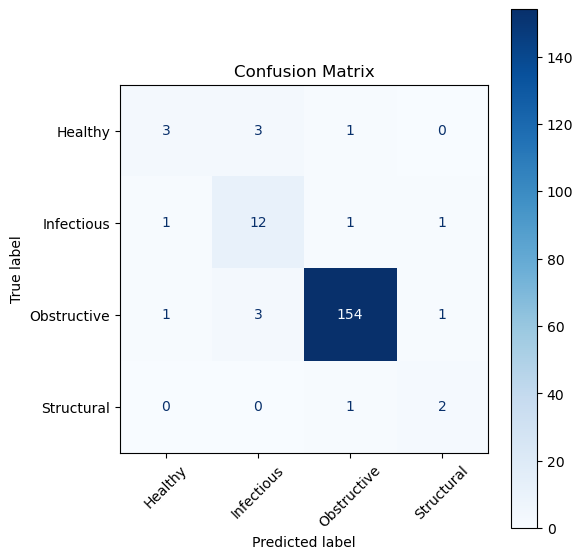

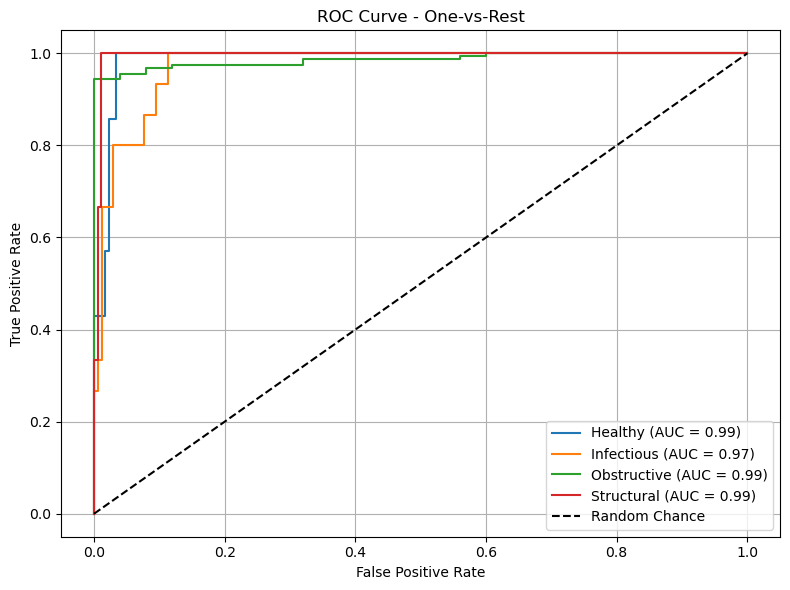

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group_encoder.classes_)

fig_cm, ax_cm = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax_cm, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

#  Logging confusion matrix to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig_cm)})

#  ROC Curve - One-vs-Rest
test_labels_binarized = label_binarize(test_labels, classes=np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

fig_roc, ax_roc = plt.subplots(figsize=(8, 6))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    ax_roc.plot(fpr[i], tpr[i], label=f"{group_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

ax_roc.plot([0, 1], [0, 1], 'k--', label='Random Chance')
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.set_title("ROC Curve - One-vs-Rest")
ax_roc.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Logging ROC to W&B
wandb.log({"ROC Curve": wandb.Image(fig_roc)})


* The confusion matrix revealed strong correct predictions for obstructive cases, with minor misclassifications between healthy/infectious and obstructive/structural categories.
* This ROC curve shows that the predictive model achieves excellent classification performance across all categories (Healthy, Infectious, Obstructive, Structural), with AUC values near 0.99, indicating high true positive rates and minimal false positives.

### Model Saving and Logging as Artifact

This section saves the trained ResNet-18 model's state dictionary to a local file for future reuse or inference. It also logs the saved model as a versioned artifact in Weights & Biases (wandb), including metadata such as architecture, input type, label classes, training configuration, and class weights. This enables model version control, reproducibility, and easy sharing across experiments or collaborators.



In [ ]:
import os
import torch
import wandb

# Define the model path in your Google Drive
model_save_path = "C:/Users/sumit/Documents/resnet18_20epoch_grouped.pth"

# Save model state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Log model as an artifact to Weights & Biases
artifact = wandb.Artifact(
    name="resnet18_20epoch-icbhi-grouped",
    type="model",
    description="ResNet18 model trained on ICBHI with grouped diagnosis labels",
    metadata={
        "architecture": "ResNet18",
        "input": "2D Spectrograms",
        "labels": list(group_encoder.classes_),
        "epochs": 20,
        "optimizer": "Adam",
        "loss": "Weighted CrossEntropy",
        "class_weights": class_weights.cpu().numpy().tolist()
    }
)

artifact.add_file(model_save_path)
wandb.log_artifact(artifact)

Model saved to: C:/Users/sumit/Documents/resnet18_20epoch_grouped.pth


<Artifact resnet18_20epoch-icbhi-grouped>

### Fine-Tuning with Additional Layer Unfreezing

In this step, the `layer3` block of the pretrained ResNet-18 model is unfrozen to enable deeper fine-tuning. The optimizer is re-initialized to include the newly trainable parameters.

The model is trained for 5 additional epochs with metrics such as accuracy, precision, recall, F1 score, and ROC AUC calculated at each epoch. These are logged to Weights & Biases (wandb) for experiment tracking. This approach helps improve model performance by gradually increasing learning capacity while preserving learned features.



In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
)
import torch.nn.functional as F
import numpy as np

# ✅ Unfreeze layer3
for name, param in model.named_parameters():
    if 'layer3' in name:
        param.requires_grad = True

# ✅ Reinitialize optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# ✅ Training loop (5 epochs)
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    all_preds, all_labels, all_probs = [], [], []

    for X, y in train_loader:
        # ✅ Move data to GPU and cast labels to LongTensor
        X, y = X.to(device), y.long().to(device)

        optimizer.zero_grad()
        outputs = model(X)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())

    # ✅ Metrics calculation
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    try:
        auc = roc_auc_score(
            y_true=np.eye(num_classes)[all_labels],
            y_score=all_probs,
            average='weighted',
            multi_class='ovr'
        )
    except:
        auc = None

    # ✅ Log to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": total_loss,
        "train_accuracy": acc,
        "train_f1": f1,
        "train_precision": precision,
        "train_recall": recall,
        "train_auc": auc if auc is not None else 0.0
    })

    print(f"Epoch {epoch} | Train Loss: {total_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | "
          f"Precision: {precision:.4f} | Recall: {recall:.4f} | AUC: {auc if auc is not None else 'NA'}")


Epoch 1 | Train Loss: 0.7717 | Acc: 0.9864 | F1: 0.9867 | Precision: 0.9874 | Recall: 0.9864 | AUC: 0.9985797206456547
Epoch 2 | Train Loss: 0.4182 | Acc: 0.9973 | F1: 0.9973 | Precision: 0.9973 | Recall: 0.9973 | AUC: 0.9999083923987478
Epoch 3 | Train Loss: 0.5120 | Acc: 0.9959 | F1: 0.9959 | Precision: 0.9960 | Recall: 0.9959 | AUC: 0.9999539740404251
Epoch 4 | Train Loss: 0.1956 | Acc: 1.0000 | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | AUC: 1.0
Epoch 5 | Train Loss: 0.1959 | Acc: 1.0000 | F1: 1.0000 | Precision: 1.0000 | Recall: 1.0000 | AUC: 1.0


### Final Model Evaluation on Test Set (After Fine-Tuning)

This section performs a final evaluation of the model on the test set after fine-tuning. Predictions and class probabilities are collected in inference mode. Key performance metrics—including accuracy, precision, recall, F1 score, and ROC AUC—are computed using a weighted average to reflect class imbalance.

A classification report provides a detailed per-class breakdown, and a confusion matrix is plotted to visualize prediction errors across diagnosis groups. All evaluation metrics are logged to Weights & Biases (wandb) for consistent experiment tracking and comparison.



Test Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         7
  Infectious       0.48      0.87      0.62        15
 Obstructive       0.98      0.94      0.96       159
  Structural       0.67      0.67      0.67         3

    accuracy                           0.90       184
   macro avg       0.53      0.62      0.56       184
weighted avg       0.90      0.90      0.89       184

Test Accuracy:  0.8967
Test F1 Score:  0.8922
Test Precision: 0.8973
Test Recall:    0.8967
Test ROC AUC:   0.9586


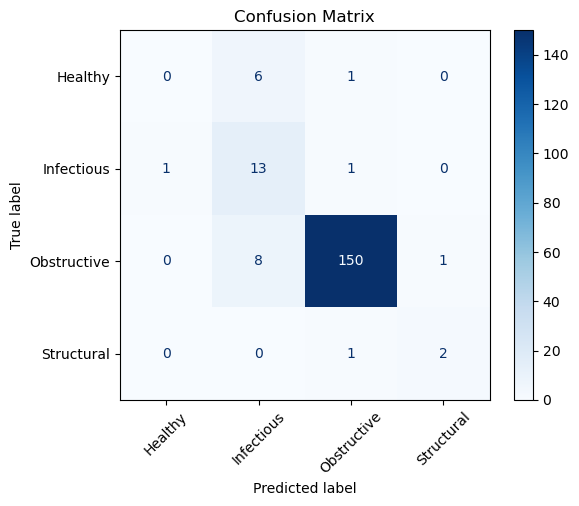

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Evaluation on test set
model.eval()
test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_probs = np.array(test_probs)

# Weighted Metrics
test_acc = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')

# AUC
try:
    test_auc = roc_auc_score(
        y_true=np.eye(num_classes)[test_labels],
        y_score=test_probs,
        average='weighted',
        multi_class='ovr'
    )
except Exception as e:
    test_auc = None
    print("AUC could not be computed:", str(e))

# Printing Classification report
print("Test Classification Report:")
print(classification_report(test_labels, test_preds, target_names=group_encoder.classes_))
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
if test_auc is not None:
    print(f"Test ROC AUC:   {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=group_encoder.classes_)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

# Logging to wandb
wandb.log({
    "test/accuracy": test_acc,
    "test/f1_score": test_f1,
    "test/precision": test_precision,
    "test/recall": test_recall,
    "test/auc": test_auc if test_auc is not None else 0.0
})


The confusion matrix revealed strong correct predictions for obstructive cases, with minor misclassifications between healthy/infectious and obstructive/structural categories.

### Saving Fine-Tuned Model and Logging to Weights & Biases

This section saves the fine-tuned ResNet-18 model—with `layer3`, `layer4`, and `fc` layers unfrozen—to a local path for future reuse. The saved model is also logged as a versioned artifact in Weights & Biases (wandb), along with detailed metadata such as architecture, input type, label classes, optimizer, loss function, training epochs, and class weights. This ensures reproducibility, traceability, and easy retrieval of model versions across training experiments.



In [ ]:
import os
import torch
import wandb

# Define the model path in your Google Drive
model_save_path = "C:/Users/sumit/Documents/resnet18_3lyr_grouped.pth"

# Save model state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# Log model as an artifact to Weights & Biases
artifact = wandb.Artifact(
    name="resnet18_3lyr-icbhi-grouped",
    type="model",
    description="ResNet18 model trained on ICBHI with grouped diagnosis labels",
    metadata={
        "architecture": "ResNet18",
        "input": "2D Spectrograms",
        "labels": list(group_encoder.classes_),
        "epochs": 20,
        "optimizer": "Adam",
        "loss": "Weighted CrossEntropy",
        "class_weights": class_weights.cpu().numpy().tolist()
    }
)

artifact.add_file(model_save_path)
wandb.log_artifact(artifact)

Model saved to: C:/Users/sumit/Documents/resnet18_3lyr_grouped.pth


<Artifact resnet18_3lyr-icbhi-grouped>

### Grad-CAM++ Visualization and Logging

This section implements Grad-CAM++ to visualize which regions of a spectrogram the model focuses on while making predictions. After initializing the `torchcam` package and creating the output directory, the function `visualize_and_save_gradcam` is defined to overlay class activation maps on the original spectrogram images.

For each test image:
- The model performs inference and generates a class activation map using Grad-CAM++.
- The image is de-normalized and overlaid with the activation map for visual clarity.
- Predictions and ground truth labels are displayed in the plot title.
- Output images are saved locally and a few selected examples are logged to Weights & Biases (wandb) for inspection.

This step provides crucial model interpretability, enabling visual confirmation that the model is attending to meaningful patterns in respiratory sound spectrograms.


In [ ]:
#  Grad-CAM++ Integration Post Training


!pip install torchcam
import os
import wandb
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF

#  Creating output directory
output_dir = "gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

#  Grad-CAM++ visualization function
def visualize_and_save_gradcam(model, cam_extractor, input_tensor, true_label, index, class_names=None):
    model.eval()
    input_tensor = input_tensor.to(device).unsqueeze(0)
    output = model(input_tensor)
    pred_class = output.argmax().item()

    activation_map = cam_extractor(pred_class, output)[0].squeeze().cpu()
    activation_map = TF.resize(activation_map.unsqueeze(0), input_tensor.shape[2:]).squeeze()

    # De-normalizing input
    image_for_display = inv_normalize(input_tensor.squeeze().cpu())
    image_for_display = torch.clamp(image_for_display, 0, 1)

    # Creating figure
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(to_pil_image(image_for_display), alpha=0.8)
    ax.imshow(activation_map, cmap='jet', alpha=0.5)
    pred_name = class_names[pred_class] if class_names else str(pred_class)
    true_name = class_names[true_label] if class_names else str(true_label)
    ax.set_title(f"Pred: {pred_name} | True: {true_name}")
    ax.axis('off')
    plt.tight_layout()

    # Saving figure locally
    filename = f"gradcam_{index}_pred{pred_class}_true{true_label}.png"
    filepath = os.path.join(output_dir, filename)
    fig.savefig(filepath)
    plt.close(fig)

    return filepath, fig  # Return both for saving and logging

wandb.init(entity="usf-alpha-neurons",project="respiratory_diagnosis", name="gradcam-logging")  # Init W&B

class_names = list(group_encoder.classes_)
saved_paths = []
wandb_samples = []

index = 0
for X_test, y_test in test_loader:
    for i in range(len(X_test)):
        path, fig = visualize_and_save_gradcam(
            model=model,
            cam_extractor=cam_extractor,
            input_tensor=X_test[i],
            true_label=y_test[i].item(),
            index=index,
            class_names=class_names
        )
        saved_paths.append(path)

        # Saving few samples for W&B
        if len(wandb_samples) < 3:
            wandb_samples.append(wandb.Image(fig, caption=os.path.basename(path)))

        index += 1

wandb.log({"GradCAM++ Samples": wandb_samples})
print(f" Saved {len(saved_paths)} Grad-CAM images to '{output_dir}'")


✅ Saved 184 Grad-CAM images to 'gradcam_outputs'


### Improved Grad-CAM++ Visualization (Interactive)

This section defines an enhanced version of the Grad-CAM++ visualization function for model interpretability. For each test input, the function performs a forward pass to generate class predictions and extract the corresponding activation map using the specified `cam_extractor`.

Key enhancements include:
- Automatic resizing of the activation map to match the input image dimensions.
- De-normalization of the spectrogram image for human-friendly visualization.
- Overlaying the Grad-CAM++ heatmap on the original spectrogram to show which regions influenced the model's decision.
- Dynamic title showing both predicted and true class labels.

The function is then applied to the first 5 samples from the test loader to visually inspect model attention and prediction behavior.


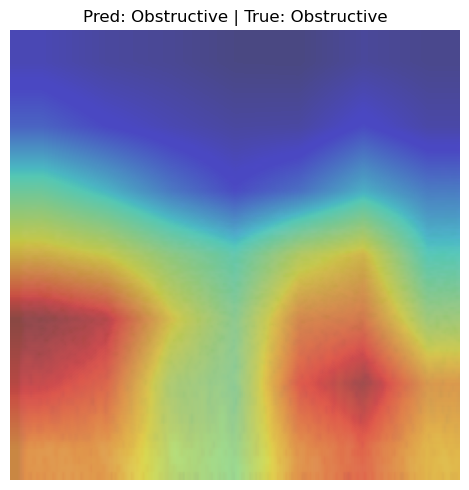

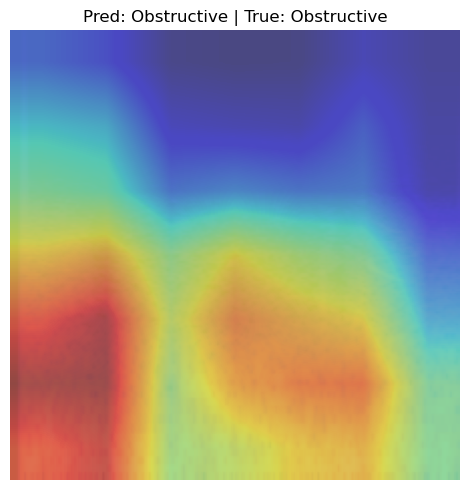

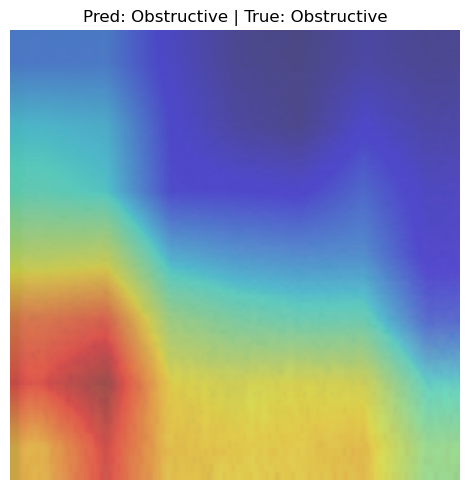

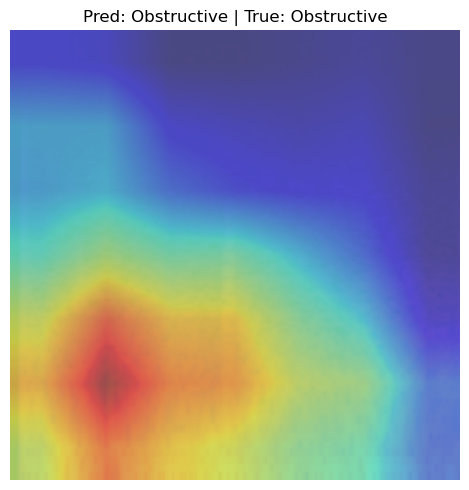

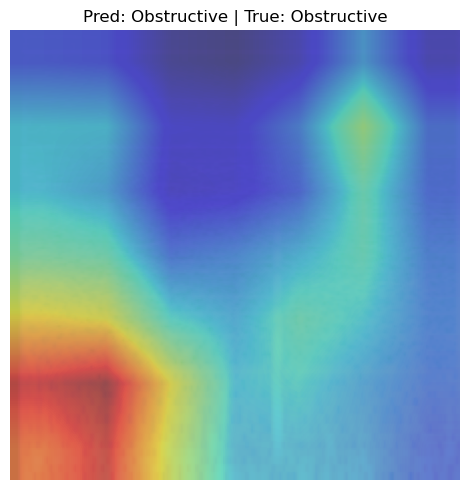

In [ ]:
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

#  Improved visualization function
def visualize_gradcam(model, cam_extractor, input_tensor, label=None, class_names=None):
    model.eval()

    # Forward pass
    input_tensor = input_tensor.to(device).unsqueeze(0)
    output = model(input_tensor)

    pred_class = output.argmax().item()
    true_class = label if label is not None else pred_class

    # Extract and upscale the Grad-CAM++
    activation_map = cam_extractor(pred_class, output)[0].squeeze().cpu()
    activation_map = TF.resize(activation_map.unsqueeze(0), input_tensor.shape[2:]).squeeze()

    # De-normalizing for visualization
    image_for_display = inv_normalize(input_tensor.squeeze().cpu())
    image_for_display = torch.clamp(image_for_display, 0, 1)

    #  Plot
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(to_pil_image(image_for_display), alpha=0.8)
    ax.imshow(activation_map, cmap='jet', alpha=0.5)
    title = f"Pred: {class_names[pred_class] if class_names else pred_class} | True: {class_names[true_class] if class_names else true_class}"
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

class_names = list(group_encoder.classes_)

for X_test, y_test in test_loader:
    for i in range(min(5, len(X_test))):  # View first 5 samples
        visualize_gradcam(
            model,
            cam_extractor,
            input_tensor=X_test[i],
            label=y_test[i].item(),
            class_names=class_names
        )
    break


### Side-by-Side Grad-CAM++ Visualization with Interpretation

This function creates a side-by-side comparison of the original spectrogram and its corresponding Grad-CAM++ heatmap overlay, providing visual insights into the model's decision-making process.

**Key Features:**
- Performs a forward pass through the model and computes the Grad-CAM++ activation map for the predicted class.
- De-normalizes the input image and overlays the activation map using a transparent color map (`jet`) for clearer interpretation.
- Displays the original spectrogram and the heatmap-enhanced version side-by-side in a single figure.
- Saves each visual output with a filename that includes both prediction and ground truth class indices.

Additionally, the function returns a **text-based explanation**, automatically generated to help interpret what the model likely focused on (e.g., crackles, wheezes, or breath patterns) in its decision. This makes the output more accessible for both technical and clinical stakeholders.


In [ ]:
def visualize_side_by_side_gradcam(model, cam_extractor, input_tensor, true_label, index, class_names=None, save_path="gradcam_outputs"):
    model.eval()

    input_tensor = input_tensor.to(device).unsqueeze(0)
    output = model(input_tensor)
    pred_class = output.argmax().item()

    activation_map = cam_extractor(pred_class, output)[0].squeeze().cpu()
    activation_map = TF.resize(activation_map.unsqueeze(0), input_tensor.shape[2:]).squeeze()

    # De-normalize input image
    image_for_display = inv_normalize(input_tensor.squeeze().cpu())
    image_for_display = torch.clamp(image_for_display, 0, 1)

    # Convert to PIL for cleaner visuals
    original_img = to_pil_image(image_for_display)

    # Create heatmap overlay image
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Spectrogram")
    axs[0].axis('off')

    axs[1].imshow(original_img, alpha=0.8)
    axs[1].imshow(activation_map, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM++ Heatmap")
    axs[1].axis('off')

    # Class names
    pred_name = class_names[pred_class] if class_names else str(pred_class)
    true_name = class_names[true_label] if class_names else str(true_label)

    fig.suptitle(f"Prediction: {pred_name} | Ground Truth: {true_name}", fontsize=14)

    # Save image
    os.makedirs(save_path, exist_ok=True)
    filename = f"combined_gradcam_{index}_pred{pred_class}_true{true_label}.png"
    fig.savefig(os.path.join(save_path, filename))
    plt.close(fig)

    # 🧠 Auto-generated interpretation
    explanation = (
        f"This sample was predicted as '{pred_name}' and the ground truth is '{true_name}'.\n"
        f"The model focused on the highlighted regions in the spectrogram, which likely capture distinguishing acoustic features "
        f"such as crackles, wheezes, or breath-phase shifts relevant to this condition.\n"
        f"Pay attention to red/yellow areas on the right — they show the most influential patterns driving the decision."
    )

    return os.path.join(save_path, filename), explanation


### Batch Generation of Grad-CAM++ Visual Explanations

This block loops through the test dataset to generate Grad-CAM++ visualizations for each sample using the `visualize_side_by_side_gradcam` function. For every spectrogram:
- A side-by-side image of the original and Grad-CAM++ heatmap is saved.
- A corresponding natural-language explanation is generated, interpreting where and why the model focused on specific spectrogram regions.

The results are stored in the `all_explanations` list as tuples of `(image_path, explanation)`, enabling easy access for reporting, review, or GUI-based display.


In [ ]:
class_names = list(group_encoder.classes_)
all_explanations = []

index = 0
for X_test, y_test in test_loader:
    for i in range(len(X_test)):
        path, explanation = visualize_side_by_side_gradcam(
            model=model,
            cam_extractor=cam_extractor,
            input_tensor=X_test[i],
            true_label=y_test[i].item(),
            index=index,
            class_names=class_names
        )
        all_explanations.append((path, explanation))
        index += 1


### Complete Grad-CAM++ Visualization, Logging, and Explanation Pipeline

This script generates Grad-CAM++ visualizations for test set samples, saves the outputs, logs selected samples to Weights & Biases (wandb), and creates human-readable explanations.

**Workflow Summary:**

1. **Function Definition**:
   - `visualize_side_by_side_gradcam()` performs model inference, extracts Grad-CAM++ activation maps, overlays them on original spectrograms, and saves side-by-side visualizations.
   - It also generates a textual explanation describing the model's focus areas in terms of potential diagnostic features like wheezes or crackles.

2. **Batch Processing**:
   - Iterates over the test DataLoader, generates visualizations and explanations for each sample, and saves them locally.
   - Stores three representative examples as `wandb.Image` objects for logging to the wandb dashboard.

3. **Outputs**:
   - All visualizations are saved in the `gradcam_outputs/` directory.
   - Explanations are saved to a text file `gradcam_explanations.txt` for documentation or presentation.
   - A sample of visualizations with explanations is logged to the wandb project run.

This process provides both visual and narrative interpretability, making model behavior more transparent and supporting clinical relevance review.


In [ ]:
import os
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
import wandb

# Create output directory
output_dir = "gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

# Get class names if using LabelEncoder
class_names = list(group_encoder.classes_) if 'group_encoder' in globals() else None

# Define function to generate and save Grad-CAM++ with explanation
def visualize_side_by_side_gradcam(model, cam_extractor, input_tensor, true_label, index, class_names=None, save_path="gradcam_outputs"):
    model.eval()
    input_tensor = input_tensor.to(device).unsqueeze(0)
    output = model(input_tensor)
    pred_class = output.argmax().item()

    activation_map = cam_extractor(pred_class, output)[0].squeeze().cpu()
    activation_map = TF.resize(activation_map.unsqueeze(0), input_tensor.shape[2:]).squeeze()

    image_for_display = inv_normalize(input_tensor.squeeze().cpu())
    image_for_display = torch.clamp(image_for_display, 0, 1)
    original_img = to_pil_image(image_for_display)

    # Side-by-side plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Spectrogram")
    axs[0].axis('off')

    axs[1].imshow(original_img, alpha=0.8)
    axs[1].imshow(activation_map, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM++ Heatmap")
    axs[1].axis('off')

    # Titles
    pred_name = class_names[pred_class] if class_names else str(pred_class)
    true_name = class_names[true_label] if class_names else str(true_label)
    fig.suptitle(f"Prediction: {pred_name} | Ground Truth: {true_name}", fontsize=14)

    # Save image
    filename = f"combined_gradcam_{index}_pred{pred_class}_true{true_label}.png"
    filepath = os.path.join(save_path, filename)
    fig.savefig(filepath)
    plt.close(fig)

    # Generate explanation text
    explanation = (
        f"Image: {filename}\n"
        f"Predicted class: {pred_name}\n"
        f"True class: {true_name}\n"
        f"The model focused on the highlighted regions (red/yellow) of the spectrogram to make its decision.\n"
        f"These areas likely represent important features such as wheezes or crackles.\n"
        "Compare the left (original) and right (Grad-CAM++) panels for visual interpretation.\n"
    )

    return filepath, explanation, fig

# 🔁 Process test set and collect explanations
all_explanations = []
sample_wandb_images = []

wandb.init(project="your_project_name", name="gradcam-logging-run")  # Init W&B

index = 0
for X_test, y_test in test_loader:
    for i in range(len(X_test)):
        path, explanation, fig = visualize_side_by_side_gradcam(
            model=model,
            cam_extractor=cam_extractor,
            input_tensor=X_test[i],
            true_label=y_test[i].item(),
            index=index,
            class_names=class_names
        )
        all_explanations.append((path, explanation))

        if len(sample_wandb_images) < 3:
            sample_wandb_images.append(wandb.Image(fig, caption=explanation.replace('\n', ' ')))

        index += 1

# ✅ Save all explanations to file
with open("gradcam_explanations.txt", "w", encoding="utf-8") as f:
    for path, explanation in all_explanations:
        f.write(explanation + "\n\n")

# ✅ Log 3 example images + explanations to Weights & Biases
wandb.log({"GradCAM++ Samples": sample_wandb_images})
print(f"✅ All Grad-CAM++ images saved to '{output_dir}'")
print(f"📄 Explanations saved to 'gradcam_explanations.txt'")


✅ All Grad-CAM++ images saved to 'gradcam_outputs'
📄 Explanations saved to 'gradcam_explanations.txt'


### Context-Aware Grad-CAM++ Visualization with Dynamic Explanations

This enhanced visualization pipeline builds on previous Grad-CAM++ functionality by adding a `generate_dynamic_explanation()` method that analyzes the **spatial focus** of the model's attention and provides more **context-aware, clinically relevant interpretations**.

#### Key Components:

- **`generate_dynamic_explanation()`**:
  - Inspects the location of the maximum activation in the Grad-CAM++ heatmap.
  - Classifies the region into one of nine zones (e.g., upper-left, middle-center).
  - Maps activation zones and predicted class to medically relevant patterns, e.g.:
    - *Obstructive*: focuses on prolonged expiratory airflow.
    - *Restrictive*: detects shortened or weak inspiratory effort.
    - *Normal*: attention is diffuse or minimal.
  - Notes if prediction mismatches the ground truth to flag possible misclassifications.

- **`visualize_side_by_side_gradcam()`**:
  - Generates side-by-side visualizations of the original spectrogram and the Grad-CAM++ heatmap.
  - Uses the `generate_dynamic_explanation()` function to create a textual summary tailored to each sample.
  - Saves the figure locally and returns the image path, explanation, and figure object for further use.

This upgrade transforms raw model outputs into interpretable and clinically relevant visual insights, helping both developers and domain experts understand model decisions in a more human-centric way.


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

def generate_dynamic_explanation(activation_map, pred_name, true_name):
    """
    Analyze the activation map and return a context-aware explanation.
    """
    explanation = f"🧠 Prediction: '{pred_name}' | Ground truth: '{true_name}'\n"

    # Analyze heatmap region
    heat = activation_map.numpy()
    h, w = heat.shape
    max_loc = np.unravel_index(np.argmax(heat), heat.shape)
    row, col = max_loc

    vertical_zone = "upper" if row < h // 3 else "middle" if row < (2 * h) // 3 else "lower"
    horizontal_zone = "left" if col < w // 3 else "center" if col < (2 * w) // 3 else "right"

    explanation += f"🔍 Model attention focused in the **{vertical_zone}-{horizontal_zone}** region of the spectrogram.\n"

    if "Obstructive" in pred_name:
        explanation += (
            "📌 This focus likely highlights **prolonged expiratory airflow**, suggestive of wheezing or airway narrowing — "
            "characteristics of obstructive lung diseases such as **COPD** or **asthma**.\n"
        )
    elif "Restrictive" in pred_name:
        explanation += (
            "📌 The model may have detected **shortened breath cycles** or **weakened inspiratory effort**, "
            "typical of restrictive patterns like **pulmonary fibrosis**.\n"
        )
    elif "Normal" in pred_name:
        explanation += (
            "✅ The attention is diffuse or subtle, suggesting the model found **no major pathological features** — "
            "consistent with a healthy respiratory pattern.\n"
        )
    else:
        explanation += (
            "⚠️ The heatmap suggests **non-specific or ambiguous focus**. Further manual review might be warranted.\n"
        )

    if pred_name != true_name:
        explanation += "❗ Prediction **does not match** ground truth — possible borderline or misclassified case.\n"

    return explanation


def visualize_side_by_side_gradcam(model, cam_extractor, input_tensor, true_label, index,
                                   class_names=None, save_path="gradcam_outputs"):
    model.eval()
    input_tensor = input_tensor.to(device).unsqueeze(0)
    output = model(input_tensor)
    pred_class = output.argmax().item()

    activation_map = cam_extractor(pred_class, output)[0].squeeze().cpu()
    activation_map = TF.resize(activation_map.unsqueeze(0), input_tensor.shape[2:]).squeeze()

    # De-normalize input
    image_for_display = inv_normalize(input_tensor.squeeze().cpu())
    image_for_display = torch.clamp(image_for_display, 0, 1)
    original_img = to_pil_image(image_for_display)

    # Class labels
    pred_name = class_names[pred_class] if class_names else str(pred_class)
    true_name = class_names[true_label] if class_names else str(true_label)

    # Side-by-side visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original_img)
    axs[0].set_title("Original Spectrogram")
    axs[0].axis('off')

    axs[1].imshow(original_img, alpha=0.8)
    axs[1].imshow(activation_map, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM++ Heatmap")
    axs[1].axis('off')

    fig.suptitle(f"Prediction: {pred_name} | Ground Truth: {true_name}", fontsize=14)
    plt.tight_layout()

    # Save figure
    os.makedirs(save_path, exist_ok=True)
    filename = f"combined_gradcam_{index}_pred{pred_class}_true{true_label}.png"
    filepath = os.path.join(save_path, filename)
    fig.savefig(filepath)
    plt.close(fig)

    # Generate explanation
    explanation = generate_dynamic_explanation(activation_map, pred_name, true_name)

    return filepath, explanation, fig


### Batch Grad-CAM++ Generation with Dynamic Explanations (Test Set)

This loop processes a batch of test samples to generate visual interpretations and accompanying natural-language explanations using the upgraded `visualize_side_by_side_gradcam()` function.

For each test input:
- A side-by-side image is created showing the original spectrogram and the corresponding Grad-CAM++ heatmap.
- The `generate_dynamic_explanation()` function analyzes the model’s attention map to provide a contextual interpretation based on both the spatial focus and predicted class.
- Each `(image_path, explanation)` pair is stored in `all_explanations` for further documentation or reporting.

The `break` statement currently limits processing to the first batch only, which can be removed to process the full test set.


In [ ]:
all_explanations = []
for X_test, y_test in test_loader:
    for i in range(len(X_test)):
        path, explanation, fig = visualize_side_by_side_gradcam(
            model=model,
            cam_extractor=cam_extractor,
            input_tensor=X_test[i],
            true_label=y_test[i].item(),
            index=i,
            class_names=class_names  # optional
        )
        all_explanations.append((path, explanation))
    break  # remove this if you want full test set


### Saving Grad-CAM++ Explanations to File

This step writes all dynamically generated Grad-CAM++ explanations to a text file (`gradcam_explanations.txt`). Each explanation is saved with two line breaks in between for readability. This file serves as a documented record of how the model interpreted specific cases, and can be useful for qualitative review, clinical feedback, or report inclusion.


In [ ]:
with open("gradcam_explanations.txt", "w", encoding="utf-8") as f:
    for path, explanation in all_explanations:
        f.write(f"{explanation}\n\n")


### Exporting Grad-CAM++ Explanations to an HTML Report

This function creates a clean, styled HTML report combining Grad-CAM++ images and their associated dynamic explanations. Using the `Jinja2` templating engine, each image and its interpretation are displayed in a well-structured, scrollable format suitable for presentations or sharing with stakeholders.

**Key Features:**
- Each entry includes the image filename, the Grad-CAM++ visualization, and a formatted explanation.
- CSS styling enhances readability and aesthetics, with borders, shadows, and clear visual hierarchy.
- The output is saved as `GradCAM_Report.html`, viewable in any browser.

This report serves as a powerful deliverable for communicating model interpretability and performance in a human-readable format.


In [ ]:
from jinja2 import Template
import os

def export_explanations_to_html(explanations, output_html_path="GradCAM_Report.html"):
    template = Template('''
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <title>Grad-CAM++ Report</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                padding: 40px;
                background-color: #f9f9f9;
                color: #333;
            }
            .entry {
                background-color: #fff;
                border: 1px solid #ddd;
                border-radius: 10px;
                padding: 20px;
                margin-bottom: 40px;
                box-shadow: 0 2px 5px rgba(0,0,0,0.05);
            }
            .entry img {
                max-width: 100%;
                border-radius: 6px;
                margin-top: 10px;
                margin-bottom: 20px;
            }
            .entry h2 {
                font-size: 18px;
                margin-bottom: 10px;
                color: #007acc;
            }
            .entry pre {
                background-color: #f1f1f1;
                padding: 10px;
                border-radius: 5px;
                overflow-x: auto;
                font-size: 14px;
            }
        </style>
    </head>
    <body>
        <h1>Grad-CAM++ Visual Explanations</h1>
        <p>Total Samples: {{ entries|length }}</p>
        {% for img_path, explanation in entries %}
        <div class="entry">
            <h2>{{ img_path.split('/')[-1] }}</h2>
            <img src="{{ img_path }}" alt="GradCAM Image">
            <pre>{{ explanation }}</pre>
        </div>
        {% endfor %}
    </body>
    </html>
    ''')

    html_content = template.render(entries=explanations)

    with open(output_html_path, "w", encoding="utf-8") as f:
        f.write(html_content)

    print(f"✅ HTML report saved to: {os.path.abspath(output_html_path)}")
export_explanations_to_html(all_explanations)


✅ HTML report saved to: C:\Users\sumit\Downloads\GradCAM_Report.html


### `wandb.finish()`

This command finalizes the current Weights & Biases run, ensuring all metrics, artifacts, and visualizations are successfully logged and uploaded to the wandb dashboard. It is essential to include this at the end of your script to prevent incomplete or hanging runs.


In [ ]:
wandb.finish()

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁▁▂▂▂
test/accuracy,█▁
test/auc,█▁
test/f1_score,█▁
test/precision,█▁
test/recall,█▁
train_accuracy,▁▆▇██████████████████████
train_auc,▁████
train_f1,▁▇▆██
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▃▄▂▂
train_precision,▁▇▆██


## 🧾 Conclusion

This project successfully demonstrates an end-to-end deep learning pipeline for respiratory condition classification using spectrograms derived from auscultation audio. Leveraging a ResNet-18 model with transfer learning, the workflow incorporates data preprocessing, spectrogram generation, class balancing, training with stratified splits, and advanced interpretability using Grad-CAM++.

The integration of Weights & Biases (wandb) provided robust experiment tracking and artifact management, while the dynamic Grad-CAM++ visualizations and natural language explanations enhanced the transparency and interpretability of model predictions.

By combining data science, medical domain relevance, and model explainability, this project lays a strong foundation for future work in interpretable AI for healthcare diagnostics. Future directions could include:
- Expanding the dataset to include more diverse respiratory sounds,
- Deploying the model as a mobile diagnostic assistant,
- Incorporating real-time signal processing for live predictions.

This project highlights the value of explainable AI in clinical decision support and contributes to ongoing efforts to make AI more transparent and trustworthy in sensitive domains like healthcare.
